*General Principles*
==========================

This is my attempt reproducing fast-ai, 8 point system namely,
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

**Premilinary**

First setup for the fast ai stuff
Reload all the modules and inline plotting

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Basic fast ai import libraries

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

fast ai libraries

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

Set up data path

In [4]:
PATH='data/dogbreed/'
TRAINDIR='train'
LABELS='labels.csv'

Check for CUDA and GPU availability
Set it up if needed
This leads to faster learning

In [5]:
torch.cuda.is_available()
torch.backends.cudnn.enabled

True

**Data Pre-Processing**

Check the data, read the csv file and load the labels to see how the counts are
Usually we want all the classes to have similar number of samples

In [6]:
df = pd.read_csv(f'{PATH}/{LABELS}'); df[:10]

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


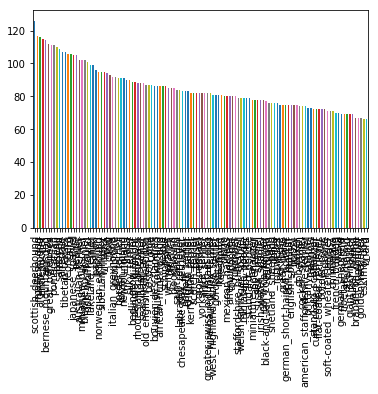

In [7]:
df['breed'].value_counts().plot(kind='bar')

**Picking an Pre-Trained Architecture**

Set the architecture and image size
Let use a pre-trained model for now.

In [8]:
arch=resnext101_64
sz=224
bs=58
n = len(list(open(f'{PATH}/{LABELS}')))-1
val_idx = get_cv_idxs(n)

In [9]:
len(val_idx)

2044

load the transforms for the particular architecture, This is based on the dataset at hand.
Since this is dog images we can surely do mirror Y but cannot do mirror X
We can also zoom the image a little bit

In [10]:
def get_data(size, batchsize):
    tfms=tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, TRAINDIR, f'{PATH}/{LABELS}', tfms=tfms, suffix='.jpg', bs=bs, val_idxs=val_idx)
    return data if sz>300 else data.resize(340, 'tmp')

Load the ImageClassifierData which loads all the files into a data object. Once we load this we can try to train it

In [11]:
#data = ImageClassifierData.from_csv(PATH, TRAINDIR, f'{PATH}/{LABELS}', tfms=tfms, suffix='.jpg', bs=bs, val_idxs=val_idx)
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [12]:
fn = PATH + '/'+ data.trn_ds.fnames[0]
img = PIL.Image.open(fn)
img.size

(500, 375)

**Pre-training**

The pretrain function loads the original architecture and adds a bunch of fully connected layers at the end of that. These layers can then be trained with the new data
The idea here is that we want to use the predefined architecture to see how well we do before training the whole model
Its a lot easier to start from somewhere rather than come up with a whole new architecture

In [13]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

***Learning Rate Estimation***

Learning rate is one of the hyperparameters of the Deep network which tends to cause considerable variation in the performance of the network. We use the lr_find function in the ConvLearner class to figure this out for us
Lets start with using the defaults and plot the results to see 

In [14]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████ | 128/141 [00:02<00:00, 56.24it/s, loss=16]  


Now lets plot the learning rate based on the results

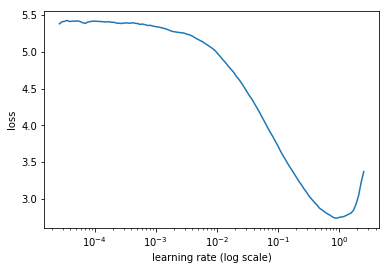

In [15]:
learn.sched.plot()

plot the loss vs learning rate to find a good learning rate. The point at which the values start bottoming out we will use as the learning rate.

In [16]:
lr = 0.01

***Fitting #1***

Fit the model with that learning rate

In [17]:
learn.fit(lr, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.176781   0.463002   0.896771  
    1      0.555943   0.355423   0.910959                    



[array([0.35542]), 0.9109589070839891]

**Re-Training**

At this point we have trained the predefined models with the last few fully connected layers. In order to better improve our results we will need to unfreeze the original architecture we loaded and then re-train those layers with the given data.

The goal here is to make the minimum possible change we can in the initial layers while making sure that model applies to the data set.The closer the layer to the image, the more likely it is some basic edge/shape detection, so less training ought to be needed.

If the data set is similar to what we originally trained with the we want the initial layers to change as less as possible(thumb rule a ratio of 10). On the other hand if we want it to work with a different set of images than the original data set we are with with a larger change(thumb rule = ratio of 3). 

In [18]:
learn.preCompute=False

In [19]:
learn.fit(lr, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.38336    0.304479   0.912916  
    1      0.350114   0.280171   0.917808                    
    2      0.301767   0.318367   0.913405                    
    3      0.280866   0.29367    0.919276                    
    4      0.266644   0.285513   0.919276                    



[array([0.28551]), 0.9192759310662629]

Save the model and then unfreeze the whole network, set the learning rate based on a differential rate and the thumb rules above

In [20]:
learn.save('%d_lastlayer' %(sz))
learn.load('%d_lastlayer' %(sz))

In [21]:
learn.set_data(get_data(299,bs))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [22]:
learn.freeze()

In [23]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.248555   0.290459   0.915362  
    1      0.235295   0.267235   0.920254                    
    2      0.220604   0.313877   0.919765                    



[array([0.31388]), 0.919765167273654]

In [24]:
learn.unfreeze()

In [25]:
diff_rate = 10
num_diff=3
lrs = [lr/(diff_rate **(num_diff-i)) for i in range(num_diff)]

In [ ]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

Save the updated model

In [ ]:
learn.save('%d_all' %(sz))
learn.load('%d_all' %(sz))

Run this again with updated learning rates based on the current model

In [ ]:
lrf=learn.lr_find()
learn.sched.plot()

In [ ]:
lr = 0.05
diff_rate = 10
num_diff=3
lrs = [lr/(diff_rate **(num_diff-i)) for i in range(num_diff)]
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('%d_all_final' %(sz))
learn.load('%d_all_final' %(sz))

Do test and validation using TTA

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

**Analysis**

***Confusion Matrix ***

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)